<a href="https://colab.research.google.com/github/sujoyrc/multimodal_raga_processing/blob/main/findSteadyNotes_v2_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import os
import pandas as pd
# import dtaidistance
from matplotlib import pyplot as plt
from matplotlib import ticker
import re
# from dtaidistance import dtw_ndim
# from scipy.stats import spearmanr,pearsonr
# from dtaidistance.subsequence.dtw import subsequence_alignment, subsequence_search
# from dtaidistance import dtw
# from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from itertools import groupby
from operator import itemgetter

In [4]:
# df=pd.read_csv('/media/antpc/Data/SujoyRc/IITB/RnD_Project/pitchContoursInterpolated_400/AG_Aalap1_Bag.csv')
df=pd.read_csv('AG_Aalap1_Bag.csv')

In [5]:
def split_into_segments(data, min_length = 0.5):
    '''
    Takes a pitch contour of entire pakad/aalap and splits it at parts of silence
    '''
    #data = pd.read_csv(pakad_pitch_file, names = ['time', 'pitch', 'energy'], header = 0)
    data['voiced'] = data['pitch'] != -3000 #boolean series (true if pitch is not -3000)
    voiced = np.array(data['voiced'])
    start = 0
    end = 0
    segments = []
    for i in data.index.values[1:]:
        if (not voiced[i-1]) and voiced[i]:#if preceding one is False and this one is true (start of voiced part)
            start = i
        elif voiced[i-1] and (not voiced[i]): #if preceding is True and this is False (end of voiced part)
            end = i
            if data['time'][end] - data['time'][start] >= min_length:
                segments.append((round(data['time'][start],2), round(data['time'][end],2)))
        else: #in the middle, don't do anything
            continue
    return segments

In [6]:
df_segments=split_into_segments(df)

In [7]:
len(df_segments)

28

In [8]:
f = lambda x, minval, maxval: x >= minval and x <= maxval 
f = np.vectorize(f)

In [9]:
def pcd(pitchContourDf, threshold = 1, show_details = False,plot=False):
    
    #pitchContourDf = pd.read_csv(aalap_F0_path)
    silRemoved = pitchContourDf.loc[pitchContourDf.pitch != -3000] #remove silence part
    pitch = silRemoved.pitch
    time = silRemoved.time

    xlim_min100 = pitch.min() - pitch.min()%100  #minimum pitch (nearest multiple of 100)
    xlim_max = pitch.max() #maximum pitch
    fig, axis1 = plt.subplots(1,1,figsize = (20,6))
    
    counts,bins,patches = axis1.hist(pitch,bins = np.arange(-1200+5,2400,10), #bins are (-5 to 5), (5 to 15), and so on
                                     edgecolor = 'white',density=True)

    centres = bins[:-1] + 5 #centres of the bins: ...-10,0,10,20,...
    counts = counts * 1000 #normalising intensities to a scale of 0 to 100
    
    if plot:
        axis1.plot(centres,counts) #plot joining centres of hist bars        
        axis1.set_yticks(axis1.get_yticks(), labels = axis1.get_yticks()*1000)
        axis1.set_xticks(np.arange(-1200,2401,100))
        axis1.set_xlabel("Frequency (cents)")
        axis1.set_ylabel("Intensity/Probability (on a scale of 100)")
        axis1.grid()
        axis1.set_xlim(-1200,2400)
        
    output_list = []
    plt.close()
    for i in range(-1200,2401,100): # 3 octaves
        
        if i <= xlim_min100 or i > xlim_max:
            if show_details:
                print("\ni =", i)
                print("No occurences of this frequency, 0 probability")
            output_list.append((i,0))
            continue
        
        idx_i = np.where(f(centres,i-25,i+25), True, False).nonzero()[0]
        peak_idx = np.argmax(counts[idx_i])
        prob = sum(counts[idx_i])
        output_list.append((i + (peak_idx-2)*10,prob))
        if show_details:
            print("\ni =", i)
            print("Indices:", idx_i)
            print("Bin Centres:", centres[idx_i])
            print("Counts:", counts[idx_i])
            print("Peak index:", peak_idx)
            print("Probability (on a scale of 0-100):", prob)
            print(f"Observed freq of semitone at {i} cents: {i + (peak_idx-2)*10} cents (#10cent-shifts: {peak_idx-2})")    
    
    return np.array([x[0] for x in output_list if x[1] > threshold]),counts,bins,patches

In [10]:
bins,counts,bins_hist,patches=pcd(df,plot=True)

In [11]:
def check_conditions_on_window(arr,bins,cents_deviation=25):
    min_value=np.nanmin(arr)
    max_value=np.nanmax(arr)
    if max_value-min_value<2*cents_deviation:
        range_flag=True
    else:
        return False
    max_gap=np.max([x%100 if x%100<50 else 100-(x%100) for x in bins])
    if max_gap+cents_deviation>49:
        max_gap=49-cents_deviation   # this is only a check to prevent getting tagged to something else
        
    broader_range=cents_deviation+max_gap
    mod_100=arr%100
    
    check_flag=np.logical_or(mod_100 < broader_range, mod_100 > 100-broader_range).all()
    if not check_flag:
        return False
    
    closest_cent=np.unique(np.round(arr/100)*100)[0]    
    closest_bin=bins[np.argmin(np.abs(bins-closest_cent))]
    if closest_bin-closest_cent>50:
        return False
    
    return_flag=(np.abs(arr-closest_bin)<=cents_deviation).all()
    
    
    return return_flag

In [12]:
def find_steady_notes(df,silence_delim_segmnets,bins,window_length=25,cents_deviation=25):
    windows=[]
    window_started=False
    dont_update_start=0
    for segment_counter in range(len(silence_delim_segmnets)):
        each_segment=df_segments[segment_counter]
        segment_start=each_segment[0]
        segment_end=each_segment[1]
        start=segment_start
        segment_data=df[(df['time']>=segment_start) & (df['time']<=segment_end)]
        end=round(start+window_length/100,2)
        while end<=segment_end:
            this_window=segment_data[(segment_data['time']>=start) & (segment_data['time']<=end)]['pitch'].values
            range_this_window=np.max(this_window)-np.min(this_window)
            max_val=round(np.max(this_window),2)
            min_val=round(np.min(this_window),2)
            steady_window=check_conditions_on_window(this_window,bins)
            #print (start,end,steady_window,window_started)
            if steady_window:
                if window_started:
                    windows[-1][2]=end
                else:
                    this_window=[segment_counter,start,end]
                    windows.append(this_window)
                    window_started=True
                end=end+0.01
                #print (round(start,2),round(end,2),steady_window,window_started)
            else:
                if window_started:
                    start=end
                    end=round(start+window_length/100,2)
                    window_started=False
                else:
                    start=start+0.01
                    end=round(start+window_length/100,2)
                    #print ("....",start,end)
    return windows

In [13]:
steady_note_output=find_steady_notes(df,df_segments,bins)
# print (steady_note_output)

In [14]:
def get_as_df(one_df,steady_note_output):
    dicts=[]
    for k in steady_note_output:
        each_dict={}
        this_segment_df=one_df[(one_df['time']>=k[1]) & (one_df['time']<=k[2])]
        this_segment_df=this_segment_df.replace(-3000,np.nan)
        this_segment=this_segment_df['pitch'].values
        max_val=round(np.nanmax(this_segment),2)
        min_val=round(np.nanmin(this_segment),2)
        each_dict['segment_id']=k[0]
        each_dict['start_time']=k[1]
        each_dict['end_time']=k[2]
        each_dict['duration']=k[2]-k[1]
        each_dict['min_val']=min_val
        each_dict['max_val']=max_val
        each_dict['diff']=max_val-min_val
        dicts.append(each_dict)
    results_pd=pd.DataFrame(dicts)
    results_pd['last_end']=results_pd['end_time'].shift(1)
    results_pd['gap']=results_pd['start_time']-results_pd['last_end']
    return results_pd

In [15]:
def group_into_lists(lst):
    subsets = []
    for k, g in groupby(enumerate(lst), lambda i_x: i_x[0] - i_x[1]):
        subset = list(map(itemgetter(1), g))
        if len(subset) > 1:
            subsets.append(subset)
    return subsets

In [16]:
def further_sublists(A,B):
    sublists = []
    for value, group in groupby(zip(A, B), key=lambda x: x[1]):
        sublist = [x[0] for x in group]
        sublists.append(sublist)

    return sublists

In [17]:
def merge_steady_note_v2(df,steady_note_output,gap=0.1):
    df_as_dict=get_as_df(df,steady_note_output).to_dict('records')
    steady_note_final=[]
    indices_to_check=[i for i,data in enumerate(df_as_dict) if data['gap']<gap]
    prev_index=[i-1 for i in indices_to_check]
    all_indexes_to_check=list(set(indices_to_check+prev_index))
    indices_to_load=[j for j,l in enumerate(df_as_dict) if j not in all_indexes_to_check]
    #print (indices_to_load)
    for k in indices_to_load:
        steady_note_final.append(steady_note_output[k])        
    grouped=group_into_lists(all_indexes_to_check)
    for each_group in grouped:
        this_group_unique_values=[]
        for i in each_group:
            this_start=steady_note_output[i][1]
            this_end=steady_note_output[i][2]
            this_array=df[(df['time']>=this_start) & (df['time']<=this_end)]['pitch'].values
            this_array_uniq=np.unique(np.round(this_array/100)*100)[0]
            this_group_unique_values.append(this_array_uniq)
        if len(set(this_group_unique_values))==1:
            segment_id=steady_note_output[each_group[0]][0]
            start=steady_note_output[each_group[0]][1]
            end=steady_note_output[each_group[-1]][2]
            this_entry=(segment_id,start,end)
            steady_note_final.append(this_entry)
        else:
            #print (each_group,this_group_unique_values)
            subsublists=further_sublists(each_group,this_group_unique_values)
            #print (subsublists)
            for each_sublist in subsublists:
                segment_id=steady_note_output[each_sublist[0]][0]
                start=steady_note_output[each_sublist[0]][1]
                end=steady_note_output[each_sublist[-1]][2]
                this_entry=(segment_id,start,end)
                steady_note_final.append(this_entry)
                
    steady_note_final=sorted(steady_note_final,key=lambda x:x[1])
    return steady_note_final

In [18]:
merged_steady_note=merge_steady_note_v2(df,steady_note_output)

In [19]:
num_of_segments=len(df_segments)
print (num_of_segments)

28


In [20]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),borderpad=0.5,fontsize=20,framealpha=0.5)

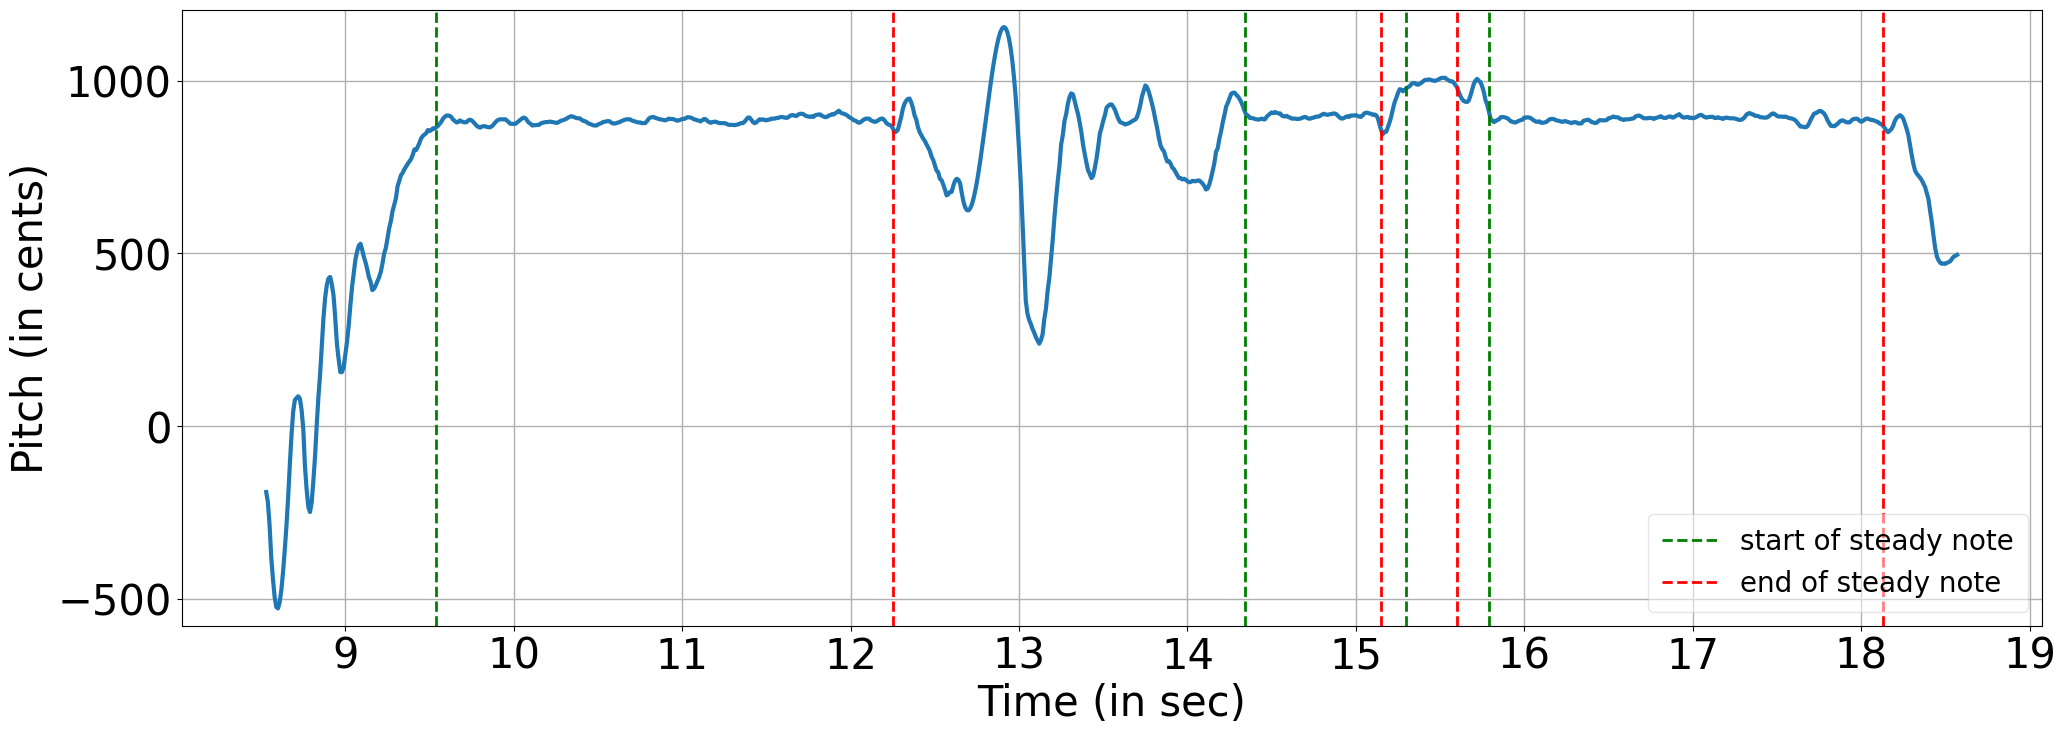

In [21]:
plt.rcParams["figure.figsize"]=(24,8*1)
plt.rcParams.update({'font.size': 30})
fig,ax=plt.subplots(nrows=1)

for i in [2]:
    k=df_segments[i]
    this_segment=df[(df['time']>=k[0]) & (df['time']<=k[1])]
    this_segment=this_segment.replace(-3000,np.nan)
    max_val=round(np.nanmax(this_segment['pitch'].values),2)
    min_val=round(np.nanmin(this_segment['pitch'].values),2)
    ax.plot(this_segment['time'],this_segment['pitch'],lw=3)
    ax.set_ylim(min_val-50,max_val+50)
    #ax.set_title('Silence Delimited Segment with steady notes')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))

    steady_this_segment=[x for x in merged_steady_note if x[0]==i]
    for each_steady in steady_this_segment:
        ax.axvline(each_steady[1],color='g',linestyle='dashed',lw=2,label='start of steady note')
        ax.axvline(each_steady[2],color='r',linestyle='dashed',lw=2,label='end of steady note')
    ax.grid(axis='both',lw=1)
    ax.set_xlabel('Time (in sec)')
    ax.set_ylabel('Pitch (in cents)')
    legend_without_duplicate_labels(ax)

In [27]:
bins

array([-310, -210, -100,   10,  190,  320,  380,  490,  710,  890, 1000,
       1190, 1400])

array([-310, -210, -100,   10,  190,  320,  380,  490,  710,  890, 1000,
       1190, 1400])

(-600.0, 1800.0)

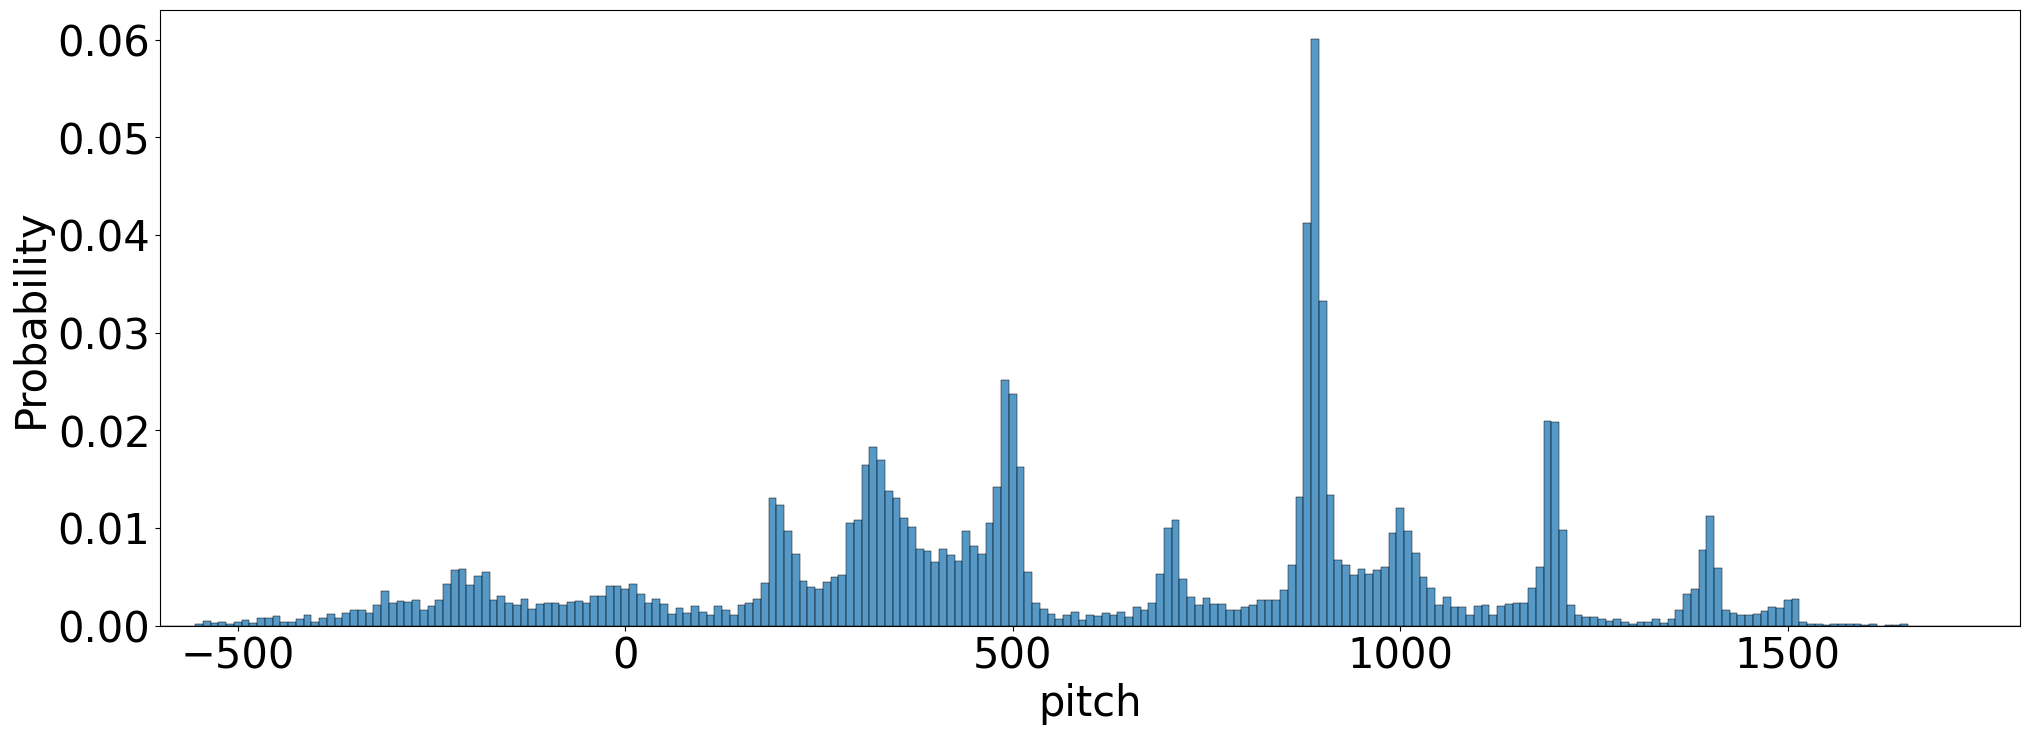

In [22]:
fig,ax=plt.subplots()
sns.histplot(df['pitch'].replace(-3000,np.nan),bins=np.arange(-1200+5,2400,10),ax=ax,stat='probability')
ax.set_xlim([-600,1800])

In [23]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig, axCenter = plt.subplots(figsize=(24, 8))
# plt.rcParams.update({'font.size': 20})

# fig.subplots_adjust(hspace=0.5)

# divider = make_axes_locatable(axCenter)
# axvert = divider.append_axes('left', size='30%', pad=0.5)


# axCenter.plot(this_segment['time'],this_segment['pitch'],lw=3)
# axCenter.set_ylim([-600,1800])
# axCenter.yaxis.set_label_position("right")
# axCenter.yaxis.tick_right()
# axCenter.grid('both')
# for each_steady in steady_this_segment:
#     axCenter.axvline(each_steady[1],color='g',linestyle='dashed',lw=2,label='start of steady note')
#     axCenter.axvline(each_steady[2],color='r',linestyle='dashed',lw=2,label='end of steady note')
# axCenter.grid(axis='both',lw=1)
# axCenter.set_xlabel('Time (in sec)')
# axCenter.set_ylabel('Pitch (in cents)')
# legend_without_duplicate_labels(axCenter)
# axCenter.axhline(890,color='k',linestyle='dashed',lw=2)

# # axhoriz.plot(xvert, sumvertical)
# sns.histplot(df['pitch'].replace(-3000,np.nan),bins=np.arange(-1200+5,2400,10),ax=axvert,stat='probability')
# axvert.set_xlim([-600,1800])
# # axvert.bar( counts, bin_edges[:-1])



# #axhoriz.margins(x=0)
# axvert.margins(y=0)

# plt.show()

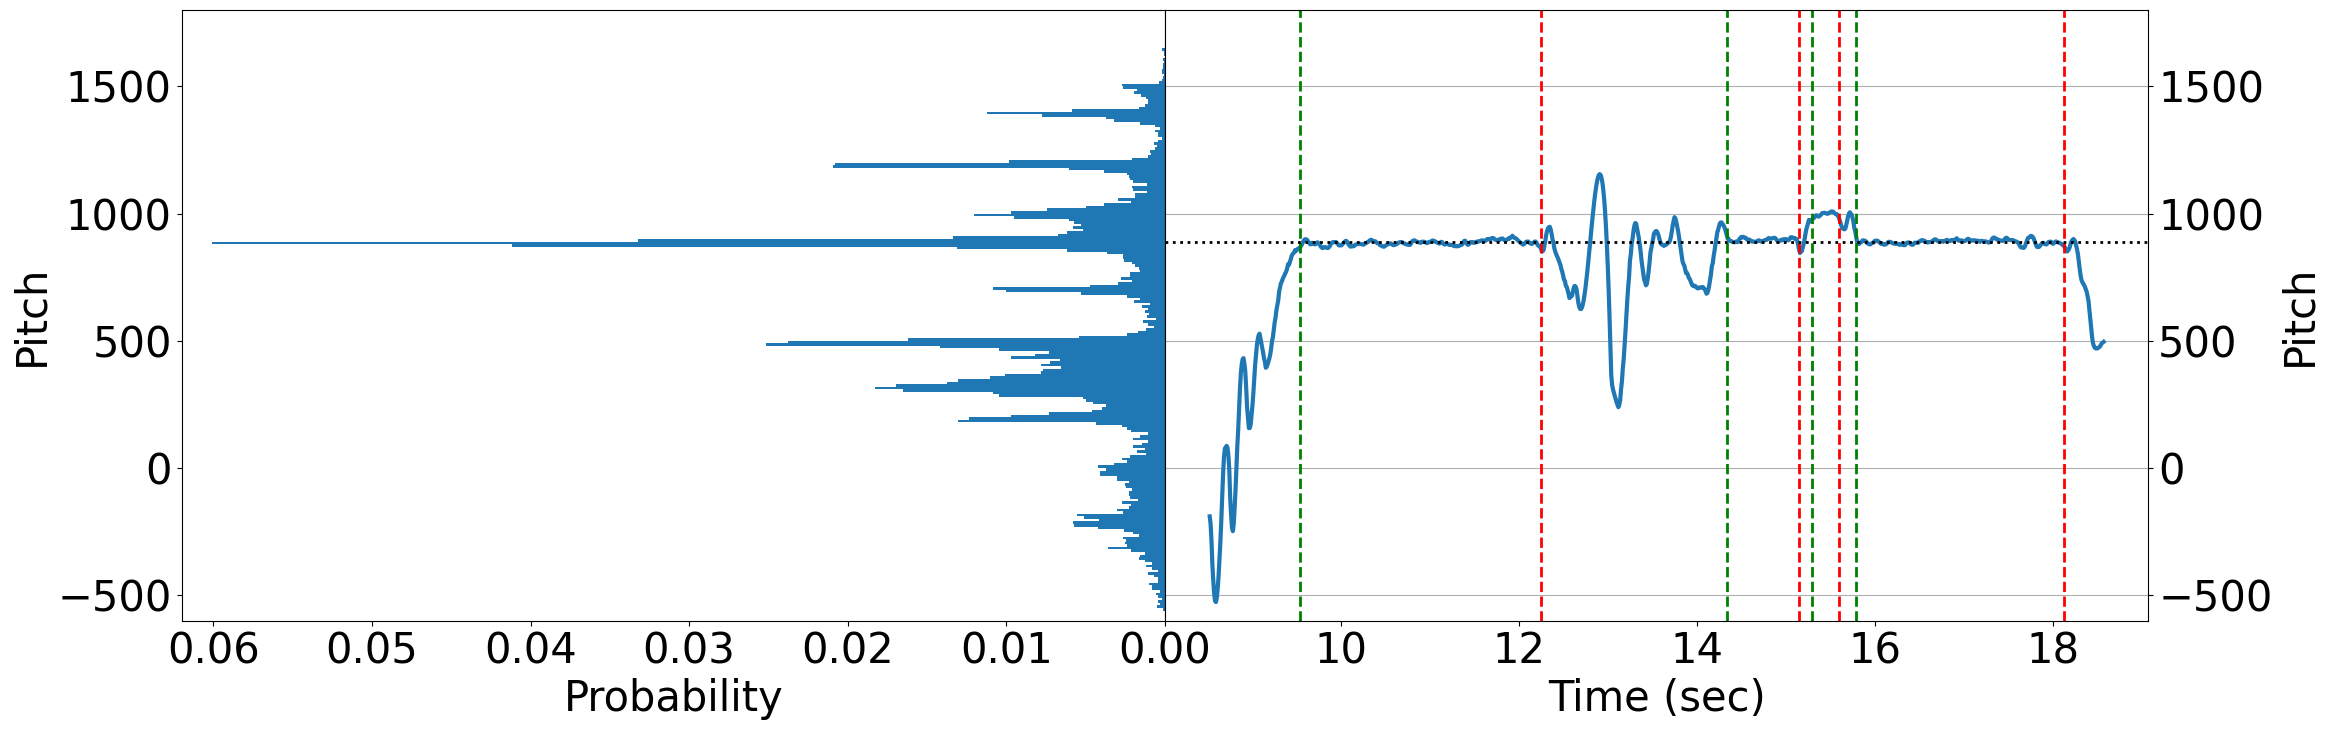

In [43]:
from matplotlib import transforms

fig, (ax1, ax2) = plt.subplots (1,2)
hist,bin_edges = np.histogram(df['pitch'].replace(-3000,np.nan),bins=np.arange(-1200+5,2400,10),density=True)
ax1.invert_xaxis()
barh1=ax1.barh(bin_edges[:-1],10*hist,height=10,align='center')
# ax1.grid(axis='y')
ax1.set_ylim([-600,1800])
ax1.set_xlabel('Probability')
ax1.set_ylabel('Pitch')
ax1.set_xlim([0.062,0])
# for l in bins:
#   ax1.axhline(l,linestyle='dashed',color='k',lw=1)

for i in [2]:
    k=(8.53, 18.58)   # This is derived by a confusing logic you can ignore
    this_segment=df[(df['time']>=k[0]) & (df['time']<=k[1])]
    this_segment=this_segment.replace(-3000,np.nan)
    max_val=round(np.nanmax(this_segment['pitch'].values),3)
    min_val=round(np.nanmin(this_segment['pitch'].values),3)
    ax2.plot(this_segment['time'],this_segment['pitch'],lw=3)
    for each_steady in steady_this_segment:
        ax2.axvline(each_steady[1],color='g',linestyle='dashed',lw=2,label='start of steady note')
        ax2.axvline(each_steady[2],color='r',linestyle='dashed',lw=2,label='end of steady note')
    ax2.axhline(890,color='k',linestyle='dotted',lw=2)
    ax2.grid(axis='y')
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylim([-600,1800])
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Pitch")
   
plt.tight_layout ()

# Adjust the spacing between the subplots
fig.subplots_adjust(wspace=0)

In [44]:
len(hist)

359

In [45]:
len(bin_edges)

360